# Single-molecule intensity time-traces test

This notebook plots some example intensity time-traces for RecB spots, to show single-step photobleaching.

The `SM_traces` object contains RecB spots that have been duplicated for 10 frames following their last frame, to measure background signal intensity after they have photobleached.

In [1]:
from pyberries.data import DatasetPool
import seaborn.objects as so
from seaborn import plotting_context

data = (DatasetPool(path='./../../BACMMAN_datasets',
                    dsList='240620_2',
                    groups='30 ng/ml',
                    filters={'all':'Frame < 50'},
                    rename_objects={'Spot_detection':'RecB_spots'},
                    rename_cols={'SpotCount':'RecBSpotCount'}
                    )
        )

Dataset 240620_2 (group 3): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid', 'SM_traces']


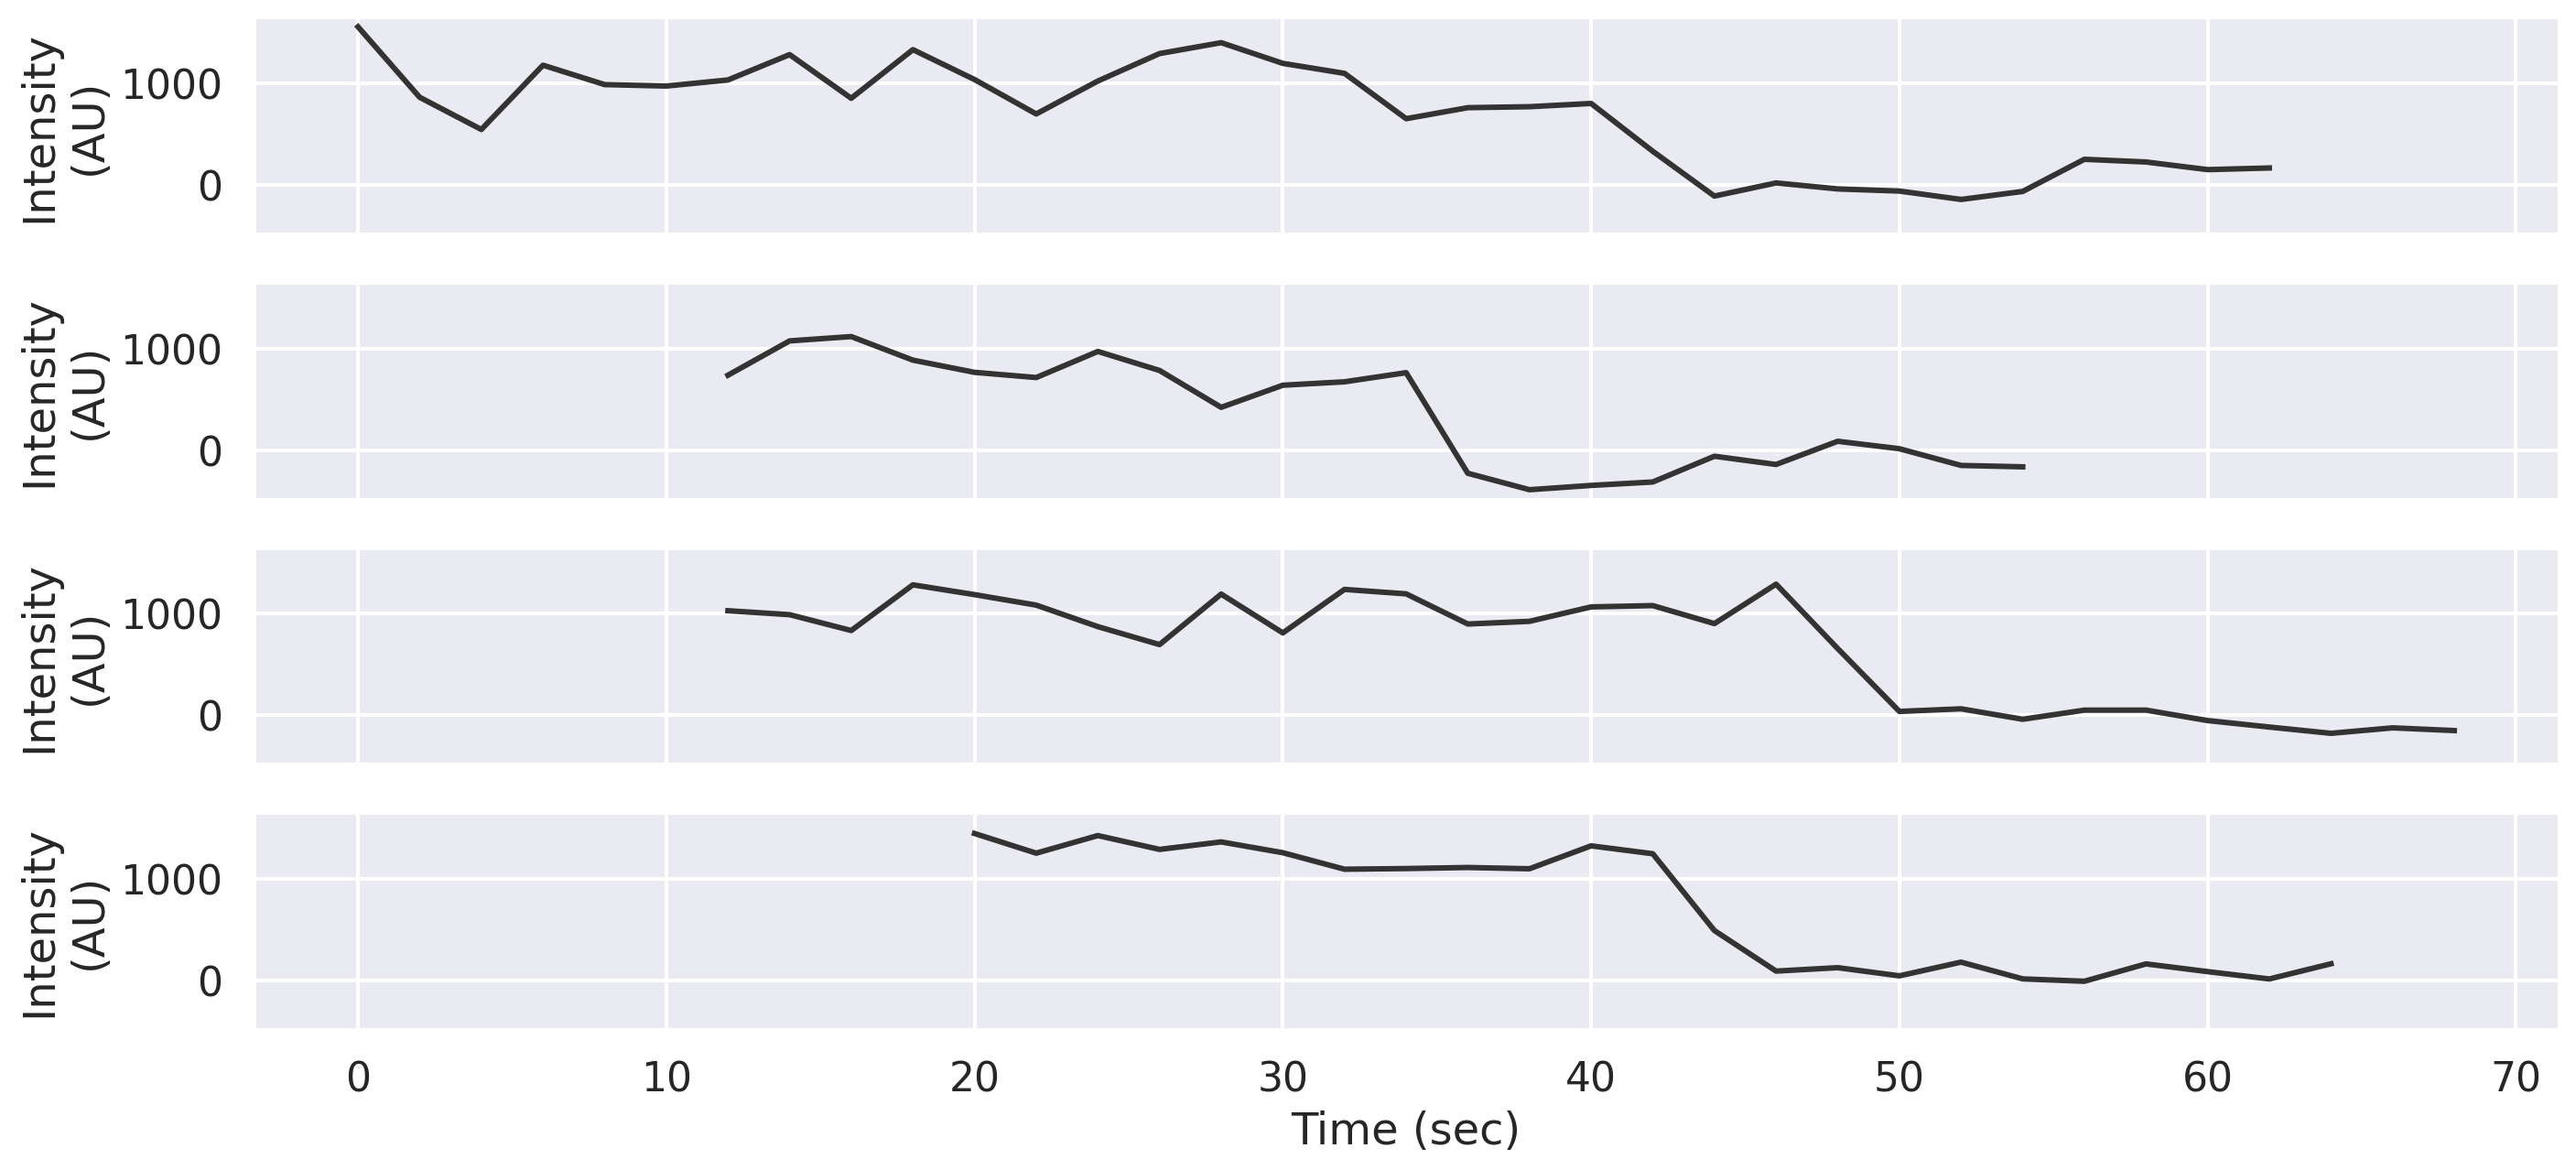

In [2]:
df = (data
      .fuse_columns(object_name='SM_traces', columns=['Dataset', 'Position', 'TrackHeadIndices'], new='spotID')
      .split_column(object_name='SM_traces', col='Indices', new_cols=['Frame', 'Cell', 'Idx'], delimiter='-')
      .SM_traces
      .assign(Cell=lambda df: df.Cell.astype('int'),
              Frame=lambda df: df.Frame.astype('int')
              )
      [['Dataset', 'PositionIdx', 'RecB_intensity', 'TrackLength', 'spotID', 'Frame', 'Cell', 'TrackHeadIndices']]
      .merge(data.Bacteria_large[['Dataset', 'PositionIdx', 'Idx', 'Frame', 'RecBIntensity']],
             suffixes=(None, '_tmp'),
             left_on=['Dataset', 'PositionIdx', 'Cell', 'Frame'],
             right_on=['Dataset', 'PositionIdx', 'Idx', 'Frame']
             )
      .assign(SNR=lambda df: df.RecB_intensity - df.RecBIntensity,
              Time=lambda df: df.Frame*2
              )
      .query('TrackLength >= 20 and PositionIdx == 2')
      .query('TrackHeadIndices != "23-15-0" and TrackHeadIndices != "24-4-0"')
      )

(
    so.Plot(df, x='Time', y='SNR', group='spotID')
    .layout(size=(15,7))
    .facet(row='TrackHeadIndices')
    .add(so.Lines(color='.2'), legend=False)
    .limit(y=(None, None))
    .label(x='Time (sec)', y='Intensity\n(AU)', title='')
    .theme(plotting_context('talk'))
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/SM_traces.svg', format='svg', bbox_inches='tight')
)